<b>Pytorch Reference - </b>
<br>
torch.nn.Linear(in_features, out_features, bias=True)
<br>
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
<br>
torch.nn.LeakyReLU(negative_slope=0.01, inplace=False)
<br>
torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
<br>
torch.nn.Upsample(size=None, scale_factor=None, mode='nearest', align_corners=None)
<br>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.


# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import copy
import time

train_file = '../input/train.csv'
test_file = '../input/test.csv'

In [3]:

class MNIST(Dataset):
    def __init__(self, csv_file: str, train=True,mask=None):
        self.train = train
        self.transform = transform=transform=transforms.Compose([transforms.ToTensor(),])
        self.mask = mask
        if self.train:
            train_df = pd.read_csv(train_file)
            test_df = pd.read_csv(test_file)
            self.train_data = train_df.iloc[:, 1:].values.reshape((-1, 28, 28)).astype(float)
            self.test_data = test_df.iloc[:, :].values.reshape((-1, 28, 28)).astype(float)
            self.train_data[:][:][:] = (self.train_data[:][:][:] -127.50) / 127.50
            self.test_data[:][:][:] = (self.test_data[:][:][:] -127.50) / 127.50
    
    def __len__(self):
        return len(self.train_data) + len(self.test_data)
        
    def __getitem__(self, index):
        if index >= len(self.train_data):
            index = index - len(self.train_data)
            image = self.test_data[index]
        else:
            image = self.train_data[index]
        image = Image.fromarray(image.astype(np.float32))
        if self.transform is not None:
            image = self.transform(image)
        return image

In [11]:
batch_size=64
dataset = MNIST(train_file, train=True,mask = None)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = 'cuda'

In [12]:
a = next(iter(dataloader))

In [13]:
a[0][0].shape

torch.Size([28, 28])

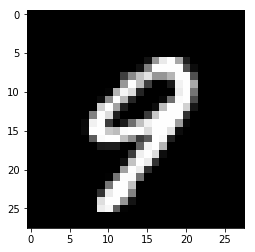

In [14]:
img = a[0][0]
plt.imshow(img,cmap='gray')

In [15]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
# generator = Sequential([
#         Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)),
#         BatchNormalization(),
#         Reshape((7,7,128)),
#         UpSampling2D(),
#         Convolution2D(64, 5, 5, border_mode='same', activation=LeakyReLU(0.2)),
#         BatchNormalization(),
#         UpSampling2D(),
#         Convolution2D(1, 5, 5, border_mode='same', activation='tanh')
#     ])

# Generator Pytorch Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(100, 128*7*7,bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.bn1 = nn.BatchNorm1d(128*7*7)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=5,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.bn2 = nn.BatchNorm2d(64)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5,padding=2),
            nn.Tanh(),
        )
    def forward(self, x):
#         print(x.shape)
        x = self.layer1(x)
#         print(x.shape)
        x = self.bn1(x)
#         print(x.shape)
        x= x.reshape((x.shape[0],128,7,7))
#         print(x.shape)
        x = self.upsample(x)
#         print(x.shape)
        x = self.layer2(x)
#         print(x.shape)
        x = self.bn2(x)
#         print(x.shape)
        x = self.upsample(x)
#         print(x.shape)
        x = self.layer3(x)
#         print(x.shape)
        return x

In [17]:
netG = Generator().to(device)
netG.apply(weights_init)
inp = torch.randn(10000)
inp = inp.view((-1,100))
output = netG(inp.to(device))

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [18]:
# discriminator = Sequential([
#         Convolution2D(64, 5, 5, subsample=(2,2), input_shape=(28,28,1), border_mode='same', activation=LeakyReLU(0.2)),
#         Dropout(0.3),
#         Convolution2D(128, 5, 5, subsample=(2,2), border_mode='same', activation=LeakyReLU(0.2)),
#         Dropout(0.3),
#         Flatten(),
#         Dense(1, activation='sigmoid')
#     ])

# Generator Pytorch Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5,stride = 2,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5,stride = 2,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.fc = nn.Sequential(
            nn.Linear(6272,1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
#         print(x.shape)
        x = self.layer1(x)
#         print(x.shape)
        x = self.layer2(x)
#         print(x.shape)
        x = x.view(x.shape[0],-1)
#         print(x.shape)
        x = self.fc(x)
#         print(x.shape)
        return x

In [19]:
netD = Discriminator().to(device)
netD.apply(weights_init)
inp = torch.randn(28*28*100)
inp = inp.view((-1,1,28,28))
output = netD(inp.to(device))

In [20]:
nottrain = False
if nottrain:
    netG.load_state_dict(torch.load("../input/dcgan-pytorch/netG.model"))
    netD.load_state_dict(torch.load("../input/dcgan-pytorch/netD.model"))
    inp = torch.randn(1000)
    inp = inp.view((-1,100))
    img = netG(inp.to(device))
    image = img[0][0].cpu().detach().numpy()
    image = image * 127.5 + 127.5
    plt.imshow(image,cmap='gray')

In [21]:
lr = 0.0002
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, 100, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))


In [22]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 50

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (images) in enumerate(dataloader, 0):
        
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netG.train()
        netD.train()
        
        netD.zero_grad()
        images = images.to(device)
        label = torch.full((images.size(0),), real_label, device=device)
        output = netD(images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(images.size(0),100, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        
        ############################################################################_______STATS________
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            netG.eval()
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
#                 fake[:] = fake[:]*127.5 + 127.5
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        

Starting Training Loop...
[0/50][0/1094]	Loss_D: 1.3931	Loss_G: 0.6924	D(x): 0.5003	D(G(z)): 0.5036 / 0.5004


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


[0/50][50/1094]	Loss_D: 0.2583	Loss_G: 4.1256	D(x): 0.8478	D(G(z)): 0.0633 / 0.0825
[0/50][100/1094]	Loss_D: 0.2849	Loss_G: 5.2754	D(x): 0.9124	D(G(z)): 0.1277 / 0.0837
[0/50][150/1094]	Loss_D: 1.3435	Loss_G: 2.8847	D(x): 0.9458	D(G(z)): 0.6483 / 0.0877
[0/50][200/1094]	Loss_D: 1.1960	Loss_G: 0.6966	D(x): 0.5055	D(G(z)): 0.3365 / 0.5270
[0/50][250/1094]	Loss_D: 1.1131	Loss_G: 1.2016	D(x): 0.6875	D(G(z)): 0.4996 / 0.3203
[0/50][300/1094]	Loss_D: 1.2827	Loss_G: 0.7528	D(x): 0.4962	D(G(z)): 0.3952 / 0.4847
[0/50][350/1094]	Loss_D: 1.2100	Loss_G: 1.0643	D(x): 0.6053	D(G(z)): 0.4760 / 0.3634
[0/50][400/1094]	Loss_D: 1.2515	Loss_G: 0.7348	D(x): 0.4667	D(G(z)): 0.3575 / 0.4905
[0/50][450/1094]	Loss_D: 1.1682	Loss_G: 1.0031	D(x): 0.6214	D(G(z)): 0.4804 / 0.3833
[0/50][500/1094]	Loss_D: 1.2609	Loss_G: 1.0666	D(x): 0.6574	D(G(z)): 0.5487 / 0.3581
[0/50][550/1094]	Loss_D: 1.1669	Loss_G: 0.8423	D(x): 0.5502	D(G(z)): 0.4112 / 0.4429
[0/50][600/1094]	Loss_D: 1.2561	Loss_G: 0.4491	D(x): 0.4263	D(G(z)

[4/50][500/1094]	Loss_D: 1.1441	Loss_G: 0.8935	D(x): 0.5250	D(G(z)): 0.3154 / 0.4399
[4/50][550/1094]	Loss_D: 1.1419	Loss_G: 0.8305	D(x): 0.5498	D(G(z)): 0.3288 / 0.4873
[4/50][600/1094]	Loss_D: 1.1387	Loss_G: 0.8948	D(x): 0.5537	D(G(z)): 0.3561 / 0.4483
[4/50][650/1094]	Loss_D: 1.1876	Loss_G: 1.3057	D(x): 0.6863	D(G(z)): 0.4930 / 0.3257
[4/50][700/1094]	Loss_D: 1.1164	Loss_G: 0.9519	D(x): 0.5403	D(G(z)): 0.3439 / 0.4327
[4/50][750/1094]	Loss_D: 1.2170	Loss_G: 0.7046	D(x): 0.4581	D(G(z)): 0.2708 / 0.5281
[4/50][800/1094]	Loss_D: 1.1789	Loss_G: 1.4856	D(x): 0.7186	D(G(z)): 0.5148 / 0.2670
[4/50][850/1094]	Loss_D: 1.2595	Loss_G: 0.6671	D(x): 0.5245	D(G(z)): 0.3771 / 0.5439
[4/50][900/1094]	Loss_D: 1.2111	Loss_G: 1.2531	D(x): 0.6668	D(G(z)): 0.4972 / 0.3203
[4/50][950/1094]	Loss_D: 1.2202	Loss_G: 1.2543	D(x): 0.6059	D(G(z)): 0.4385 / 0.3286
[4/50][1000/1094]	Loss_D: 1.2498	Loss_G: 1.2271	D(x): 0.7096	D(G(z)): 0.5447 / 0.3365
[4/50][1050/1094]	Loss_D: 1.1617	Loss_G: 1.1640	D(x): 0.6975	D(G

[8/50][950/1094]	Loss_D: 1.1051	Loss_G: 0.9550	D(x): 0.5746	D(G(z)): 0.3691 / 0.4434
[8/50][1000/1094]	Loss_D: 1.1436	Loss_G: 0.8842	D(x): 0.5486	D(G(z)): 0.3275 / 0.4660
[8/50][1050/1094]	Loss_D: 1.1822	Loss_G: 0.9146	D(x): 0.5239	D(G(z)): 0.3235 / 0.4438
[9/50][0/1094]	Loss_D: 1.0931	Loss_G: 1.3427	D(x): 0.6492	D(G(z)): 0.4264 / 0.3220
[9/50][50/1094]	Loss_D: 1.0867	Loss_G: 1.2637	D(x): 0.5893	D(G(z)): 0.3629 / 0.3253
[9/50][100/1094]	Loss_D: 1.1772	Loss_G: 1.0898	D(x): 0.5822	D(G(z)): 0.3847 / 0.3899
[9/50][150/1094]	Loss_D: 1.1042	Loss_G: 1.2603	D(x): 0.6638	D(G(z)): 0.4465 / 0.3273
[9/50][200/1094]	Loss_D: 0.9505	Loss_G: 1.1864	D(x): 0.6127	D(G(z)): 0.2976 / 0.3579
[9/50][250/1094]	Loss_D: 1.0576	Loss_G: 1.2654	D(x): 0.7256	D(G(z)): 0.4371 / 0.3328
[9/50][300/1094]	Loss_D: 1.0780	Loss_G: 0.7722	D(x): 0.5946	D(G(z)): 0.3424 / 0.5017
[9/50][350/1094]	Loss_D: 1.1289	Loss_G: 1.0237	D(x): 0.5607	D(G(z)): 0.3362 / 0.4164
[9/50][400/1094]	Loss_D: 1.0123	Loss_G: 1.1281	D(x): 0.6487	D(G(z)

[13/50][250/1094]	Loss_D: 1.1871	Loss_G: 1.0641	D(x): 0.6228	D(G(z)): 0.4229 / 0.3944
[13/50][300/1094]	Loss_D: 1.0487	Loss_G: 1.3357	D(x): 0.6489	D(G(z)): 0.3710 / 0.3217
[13/50][350/1094]	Loss_D: 1.0686	Loss_G: 1.3148	D(x): 0.6093	D(G(z)): 0.3189 / 0.3251
[13/50][400/1094]	Loss_D: 1.1938	Loss_G: 1.5128	D(x): 0.7228	D(G(z)): 0.5116 / 0.2772
[13/50][450/1094]	Loss_D: 1.1593	Loss_G: 1.2366	D(x): 0.6293	D(G(z)): 0.4125 / 0.3566
[13/50][500/1094]	Loss_D: 1.0089	Loss_G: 1.1540	D(x): 0.6138	D(G(z)): 0.3290 / 0.3779
[13/50][550/1094]	Loss_D: 1.0534	Loss_G: 0.9728	D(x): 0.5800	D(G(z)): 0.2962 / 0.4372
[13/50][600/1094]	Loss_D: 1.1880	Loss_G: 1.1575	D(x): 0.5474	D(G(z)): 0.3549 / 0.3621
[13/50][650/1094]	Loss_D: 1.0347	Loss_G: 1.2064	D(x): 0.7156	D(G(z)): 0.4360 / 0.3548
[13/50][700/1094]	Loss_D: 1.1187	Loss_G: 1.0347	D(x): 0.6056	D(G(z)): 0.3766 / 0.4079
[13/50][750/1094]	Loss_D: 1.0354	Loss_G: 0.9762	D(x): 0.6602	D(G(z)): 0.3809 / 0.4222
[13/50][800/1094]	Loss_D: 1.1927	Loss_G: 1.1958	D(x): 

[17/50][650/1094]	Loss_D: 1.0106	Loss_G: 1.3165	D(x): 0.7235	D(G(z)): 0.4362 / 0.3374
[17/50][700/1094]	Loss_D: 0.9187	Loss_G: 1.4274	D(x): 0.6637	D(G(z)): 0.3170 / 0.3086
[17/50][750/1094]	Loss_D: 0.8952	Loss_G: 1.2603	D(x): 0.6668	D(G(z)): 0.3237 / 0.3423
[17/50][800/1094]	Loss_D: 0.9907	Loss_G: 1.3383	D(x): 0.6622	D(G(z)): 0.3600 / 0.3216
[17/50][850/1094]	Loss_D: 0.9988	Loss_G: 1.3492	D(x): 0.6686	D(G(z)): 0.3791 / 0.3052
[17/50][900/1094]	Loss_D: 1.1221	Loss_G: 1.0728	D(x): 0.6515	D(G(z)): 0.4102 / 0.4189
[17/50][950/1094]	Loss_D: 1.0131	Loss_G: 1.4709	D(x): 0.6184	D(G(z)): 0.3150 / 0.2884
[17/50][1000/1094]	Loss_D: 1.1600	Loss_G: 1.0275	D(x): 0.5634	D(G(z)): 0.3096 / 0.4257
[17/50][1050/1094]	Loss_D: 0.9748	Loss_G: 1.3639	D(x): 0.6182	D(G(z)): 0.3038 / 0.3048
[18/50][0/1094]	Loss_D: 1.1645	Loss_G: 1.1895	D(x): 0.5564	D(G(z)): 0.3426 / 0.3541
[18/50][50/1094]	Loss_D: 1.1095	Loss_G: 0.9446	D(x): 0.5284	D(G(z)): 0.2429 / 0.4503
[18/50][100/1094]	Loss_D: 1.1240	Loss_G: 1.2931	D(x): 0

[21/50][1050/1094]	Loss_D: 1.1600	Loss_G: 1.2292	D(x): 0.6285	D(G(z)): 0.3966 / 0.3684
[22/50][0/1094]	Loss_D: 1.0354	Loss_G: 1.2604	D(x): 0.6178	D(G(z)): 0.3266 / 0.3601
[22/50][50/1094]	Loss_D: 1.1273	Loss_G: 1.1307	D(x): 0.6010	D(G(z)): 0.3536 / 0.4067
[22/50][100/1094]	Loss_D: 1.0649	Loss_G: 1.5132	D(x): 0.6774	D(G(z)): 0.4110 / 0.2800
[22/50][150/1094]	Loss_D: 0.9595	Loss_G: 1.3014	D(x): 0.6220	D(G(z)): 0.2855 / 0.3412
[22/50][200/1094]	Loss_D: 0.9612	Loss_G: 1.1952	D(x): 0.6416	D(G(z)): 0.3134 / 0.3711
[22/50][250/1094]	Loss_D: 1.1241	Loss_G: 1.4730	D(x): 0.6938	D(G(z)): 0.4501 / 0.3063
[22/50][300/1094]	Loss_D: 1.0635	Loss_G: 1.1348	D(x): 0.5460	D(G(z)): 0.2678 / 0.3974
[22/50][350/1094]	Loss_D: 0.9317	Loss_G: 1.2387	D(x): 0.6984	D(G(z)): 0.3613 / 0.3761
[22/50][400/1094]	Loss_D: 1.0642	Loss_G: 1.4102	D(x): 0.6886	D(G(z)): 0.4087 / 0.2964
[22/50][450/1094]	Loss_D: 0.8528	Loss_G: 1.3130	D(x): 0.6464	D(G(z)): 0.2621 / 0.3188
[22/50][500/1094]	Loss_D: 1.0474	Loss_G: 1.0564	D(x): 0.

[26/50][350/1094]	Loss_D: 1.1158	Loss_G: 1.2202	D(x): 0.6719	D(G(z)): 0.4193 / 0.3628
[26/50][400/1094]	Loss_D: 1.0837	Loss_G: 1.3080	D(x): 0.5614	D(G(z)): 0.2812 / 0.3435
[26/50][450/1094]	Loss_D: 1.0505	Loss_G: 1.3827	D(x): 0.6726	D(G(z)): 0.3842 / 0.3243
[26/50][500/1094]	Loss_D: 1.0919	Loss_G: 1.4149	D(x): 0.6440	D(G(z)): 0.3819 / 0.3159
[26/50][550/1094]	Loss_D: 1.0893	Loss_G: 1.4248	D(x): 0.6359	D(G(z)): 0.3691 / 0.3360
[26/50][600/1094]	Loss_D: 1.1229	Loss_G: 1.3240	D(x): 0.6151	D(G(z)): 0.3566 / 0.3476
[26/50][650/1094]	Loss_D: 1.0859	Loss_G: 1.1465	D(x): 0.6441	D(G(z)): 0.3932 / 0.3867
[26/50][700/1094]	Loss_D: 1.2082	Loss_G: 0.8531	D(x): 0.5149	D(G(z)): 0.2684 / 0.4837
[26/50][750/1094]	Loss_D: 1.0162	Loss_G: 1.2073	D(x): 0.6577	D(G(z)): 0.3414 / 0.3665
[26/50][800/1094]	Loss_D: 1.1421	Loss_G: 1.3667	D(x): 0.6067	D(G(z)): 0.3490 / 0.3246
[26/50][850/1094]	Loss_D: 1.0582	Loss_G: 1.3042	D(x): 0.5785	D(G(z)): 0.2910 / 0.3327
[26/50][900/1094]	Loss_D: 1.0994	Loss_G: 1.1125	D(x): 

[30/50][750/1094]	Loss_D: 1.0919	Loss_G: 1.1013	D(x): 0.6159	D(G(z)): 0.3708 / 0.3988
[30/50][800/1094]	Loss_D: 1.0593	Loss_G: 1.2179	D(x): 0.7109	D(G(z)): 0.4257 / 0.3544
[30/50][850/1094]	Loss_D: 1.0089	Loss_G: 1.4743	D(x): 0.6445	D(G(z)): 0.3545 / 0.3014
[30/50][900/1094]	Loss_D: 1.0610	Loss_G: 1.2015	D(x): 0.5883	D(G(z)): 0.3158 / 0.3659
[30/50][950/1094]	Loss_D: 0.9526	Loss_G: 1.4928	D(x): 0.6765	D(G(z)): 0.3452 / 0.2855
[30/50][1000/1094]	Loss_D: 1.0955	Loss_G: 1.5012	D(x): 0.6716	D(G(z)): 0.4106 / 0.2995
[30/50][1050/1094]	Loss_D: 1.1356	Loss_G: 1.2263	D(x): 0.6482	D(G(z)): 0.4074 / 0.3575
[31/50][0/1094]	Loss_D: 1.1434	Loss_G: 1.0322	D(x): 0.6110	D(G(z)): 0.3865 / 0.4181
[31/50][50/1094]	Loss_D: 1.0795	Loss_G: 1.0919	D(x): 0.6742	D(G(z)): 0.3919 / 0.3951
[31/50][100/1094]	Loss_D: 0.9351	Loss_G: 1.4578	D(x): 0.7010	D(G(z)): 0.3696 / 0.3058
[31/50][150/1094]	Loss_D: 1.1839	Loss_G: 1.3803	D(x): 0.5957	D(G(z)): 0.3802 / 0.3308
[31/50][200/1094]	Loss_D: 0.9953	Loss_G: 1.1610	D(x): 0

[35/50][50/1094]	Loss_D: 1.0874	Loss_G: 1.0939	D(x): 0.5769	D(G(z)): 0.3277 / 0.3891
[35/50][100/1094]	Loss_D: 0.9868	Loss_G: 1.0990	D(x): 0.6409	D(G(z)): 0.3368 / 0.3814
[35/50][150/1094]	Loss_D: 1.0309	Loss_G: 1.3431	D(x): 0.6380	D(G(z)): 0.3341 / 0.3193
[35/50][200/1094]	Loss_D: 1.1098	Loss_G: 1.5273	D(x): 0.6170	D(G(z)): 0.3560 / 0.2901
[35/50][250/1094]	Loss_D: 1.1071	Loss_G: 1.0088	D(x): 0.5280	D(G(z)): 0.2686 / 0.4456
[35/50][300/1094]	Loss_D: 1.0754	Loss_G: 1.0779	D(x): 0.5711	D(G(z)): 0.2932 / 0.4245
[35/50][350/1094]	Loss_D: 1.0853	Loss_G: 1.3156	D(x): 0.6416	D(G(z)): 0.3747 / 0.3319
[35/50][400/1094]	Loss_D: 1.0665	Loss_G: 1.3361	D(x): 0.6538	D(G(z)): 0.3762 / 0.3397
[35/50][450/1094]	Loss_D: 1.0955	Loss_G: 1.1374	D(x): 0.6055	D(G(z)): 0.3568 / 0.3995
[35/50][500/1094]	Loss_D: 1.2134	Loss_G: 1.1373	D(x): 0.7418	D(G(z)): 0.4995 / 0.3816
[35/50][550/1094]	Loss_D: 1.2009	Loss_G: 1.2547	D(x): 0.6231	D(G(z)): 0.4095 / 0.3384
[35/50][600/1094]	Loss_D: 1.2054	Loss_G: 1.1240	D(x): 0

[39/50][450/1094]	Loss_D: 1.0808	Loss_G: 1.5472	D(x): 0.5968	D(G(z)): 0.3104 / 0.2827
[39/50][500/1094]	Loss_D: 1.1905	Loss_G: 1.4571	D(x): 0.5788	D(G(z)): 0.3570 / 0.2940
[39/50][550/1094]	Loss_D: 1.1410	Loss_G: 0.9090	D(x): 0.6803	D(G(z)): 0.4484 / 0.4662
[39/50][600/1094]	Loss_D: 1.0126	Loss_G: 1.1033	D(x): 0.6921	D(G(z)): 0.3830 / 0.3867
[39/50][650/1094]	Loss_D: 0.9412	Loss_G: 1.4789	D(x): 0.6746	D(G(z)): 0.3494 / 0.2966
[39/50][700/1094]	Loss_D: 1.0488	Loss_G: 1.2178	D(x): 0.6263	D(G(z)): 0.3557 / 0.3642
[39/50][750/1094]	Loss_D: 1.1157	Loss_G: 0.9297	D(x): 0.5970	D(G(z)): 0.3509 / 0.4491
[39/50][800/1094]	Loss_D: 1.1792	Loss_G: 1.4800	D(x): 0.6414	D(G(z)): 0.3836 / 0.3008
[39/50][850/1094]	Loss_D: 1.1307	Loss_G: 0.9682	D(x): 0.6167	D(G(z)): 0.3591 / 0.4407
[39/50][900/1094]	Loss_D: 1.0359	Loss_G: 1.2568	D(x): 0.6866	D(G(z)): 0.4029 / 0.3530
[39/50][950/1094]	Loss_D: 0.8841	Loss_G: 1.3964	D(x): 0.7294	D(G(z)): 0.3482 / 0.2999
[39/50][1000/1094]	Loss_D: 1.0780	Loss_G: 1.1085	D(x):

[43/50][850/1094]	Loss_D: 0.9479	Loss_G: 1.3333	D(x): 0.6658	D(G(z)): 0.3490 / 0.3400
[43/50][900/1094]	Loss_D: 1.1696	Loss_G: 1.4064	D(x): 0.6658	D(G(z)): 0.4410 / 0.3168
[43/50][950/1094]	Loss_D: 0.9696	Loss_G: 1.1349	D(x): 0.6875	D(G(z)): 0.3694 / 0.3920
[43/50][1000/1094]	Loss_D: 0.9957	Loss_G: 1.3950	D(x): 0.6553	D(G(z)): 0.3214 / 0.3186
[43/50][1050/1094]	Loss_D: 1.0950	Loss_G: 1.1097	D(x): 0.5422	D(G(z)): 0.2690 / 0.4092
[44/50][0/1094]	Loss_D: 1.0002	Loss_G: 1.4956	D(x): 0.5974	D(G(z)): 0.2802 / 0.2941
[44/50][50/1094]	Loss_D: 0.9992	Loss_G: 1.2554	D(x): 0.6471	D(G(z)): 0.3413 / 0.3636
[44/50][100/1094]	Loss_D: 1.1001	Loss_G: 1.0362	D(x): 0.6145	D(G(z)): 0.3700 / 0.4089
[44/50][150/1094]	Loss_D: 1.0823	Loss_G: 1.2196	D(x): 0.7045	D(G(z)): 0.4309 / 0.3642
[44/50][200/1094]	Loss_D: 0.9816	Loss_G: 1.2026	D(x): 0.6068	D(G(z)): 0.2877 / 0.3730
[44/50][250/1094]	Loss_D: 1.0915	Loss_G: 1.2820	D(x): 0.6963	D(G(z)): 0.4275 / 0.3579
[44/50][300/1094]	Loss_D: 1.0564	Loss_G: 1.6317	D(x): 0

[48/50][150/1094]	Loss_D: 1.1471	Loss_G: 1.1182	D(x): 0.5471	D(G(z)): 0.3052 / 0.3868
[48/50][200/1094]	Loss_D: 1.0519	Loss_G: 1.1567	D(x): 0.6142	D(G(z)): 0.3244 / 0.3911
[48/50][250/1094]	Loss_D: 1.0668	Loss_G: 1.3007	D(x): 0.6304	D(G(z)): 0.3320 / 0.3481
[48/50][300/1094]	Loss_D: 1.0239	Loss_G: 1.1510	D(x): 0.6721	D(G(z)): 0.3850 / 0.3717
[48/50][350/1094]	Loss_D: 1.0073	Loss_G: 1.1581	D(x): 0.6402	D(G(z)): 0.3465 / 0.3780
[48/50][400/1094]	Loss_D: 1.1652	Loss_G: 1.5290	D(x): 0.7402	D(G(z)): 0.4636 / 0.2796
[48/50][450/1094]	Loss_D: 1.0105	Loss_G: 1.2379	D(x): 0.6267	D(G(z)): 0.2944 / 0.3390
[48/50][500/1094]	Loss_D: 1.1609	Loss_G: 1.5087	D(x): 0.6392	D(G(z)): 0.3954 / 0.3033
[48/50][550/1094]	Loss_D: 1.1134	Loss_G: 1.4978	D(x): 0.6009	D(G(z)): 0.3414 / 0.3003
[48/50][600/1094]	Loss_D: 1.1471	Loss_G: 1.2288	D(x): 0.6345	D(G(z)): 0.3880 / 0.3700
[48/50][650/1094]	Loss_D: 1.0553	Loss_G: 1.3602	D(x): 0.6364	D(G(z)): 0.3756 / 0.3239
[48/50][700/1094]	Loss_D: 1.0411	Loss_G: 1.3171	D(x): 

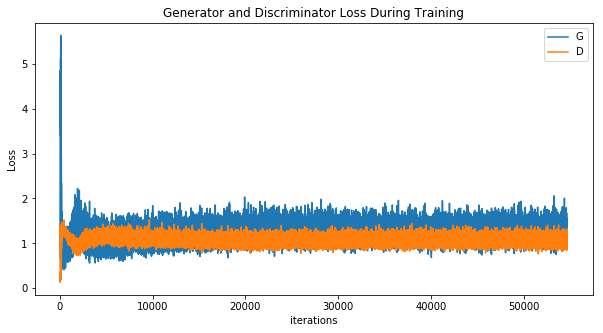

In [23]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


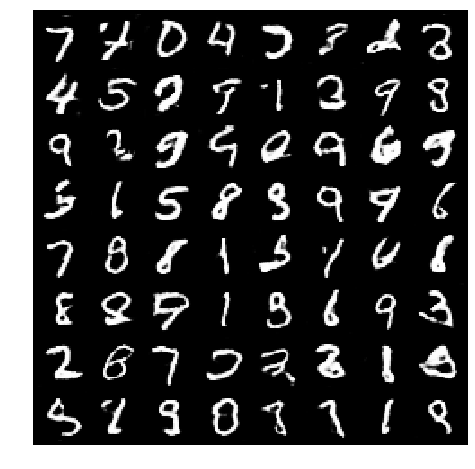

In [24]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


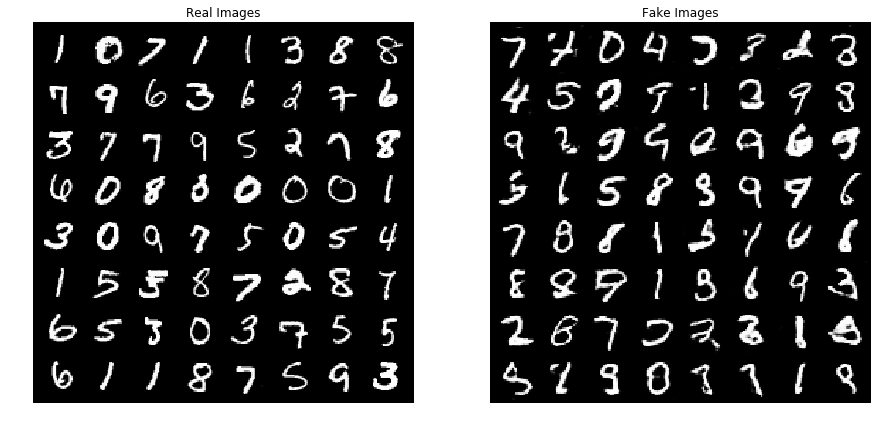

In [25]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


In [26]:
from datetime import datetime

timestamp = str(datetime.today().strftime('%Y-%m-%d-%H:%M:%S'))

torch.save(netD.state_dict(), timestamp + "-netD.model")
torch.save(netG.state_dict(), timestamp + "-netG.model")